In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)    

REPLICAS:  1


In [3]:
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x601_y501_cla

In [4]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [5]:
len(class1)

78786

In [6]:
sampled_class0 = random.sample(class0, 78786)
sampled_class1 = random.sample(class1, 78786)
len(sampled_class0)

78786

In [7]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (70, 70), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [8]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [9]:
class0_array[1]

[array([[[174, 123, 205],
         [173, 123, 200],
         [168, 119, 199],
         ...,
         [176, 129, 209],
         [172, 127, 211],
         [167, 124, 212]],
 
        [[166, 116, 196],
         [168, 118, 198],
         [166, 117, 201],
         ...,
         [176, 129, 203],
         [173, 126, 208],
         [168, 123, 211]],
 
        [[156, 105, 182],
         [158, 107, 188],
         [161, 110, 197],
         ...,
         [174, 127, 203],
         [173, 126, 209],
         [170, 124, 212]],
 
        ...,
 
        [[197, 167, 218],
         [195, 163, 213],
         [191, 155, 209],
         ...,
         [186, 147, 214],
         [186, 144, 214],
         [186, 142, 211]],
 
        [[193, 160, 216],
         [192, 157, 210],
         [193, 159, 210],
         ...,
         [189, 152, 216],
         [191, 155, 219],
         [193, 156, 219]],
 
        [[187, 148, 210],
         [184, 146, 204],
         [192, 160, 208],
         ...,
         [197, 165, 218],
  

In [10]:
test = cv2.imread('../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_COLOR)
test.shape

(50, 50, 3)

In [11]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(41)
random.shuffle(combined_data)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [12]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [13]:
X = np.array(X).reshape(-1, 70, 70, 3)

In [14]:
X.shape

(157572, 70, 70, 3)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(110300, 70, 70, 3) (47272, 70, 70, 3) (110300, 2) (47272, 2)


In [16]:
from tensorflow.keras.applications import DenseNet201

In [17]:
base_model = tf.keras.applications.DenseNet201(input_shape=(70,70,3),include_top=False,weights="imagenet")

74836368/74836368 [==============================] - 1s 0us/step


In [18]:
for layer in base_model.layers[:-5]:
    layer.trainable=False

In [19]:
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D,RepeatVector

model=Sequential()
model.add(base_model)
model.add(Dropout(0.4))

model.add(Flatten())
model.add(RepeatVector(2))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 2, 1920)        18321984  
                                                                 
 dropout (Dropout)           (None, 2, 2, 1920)        0         
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 repeat_vector (RepeatVector  (None, 2, 7680)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 2)                 30722     
                                                        

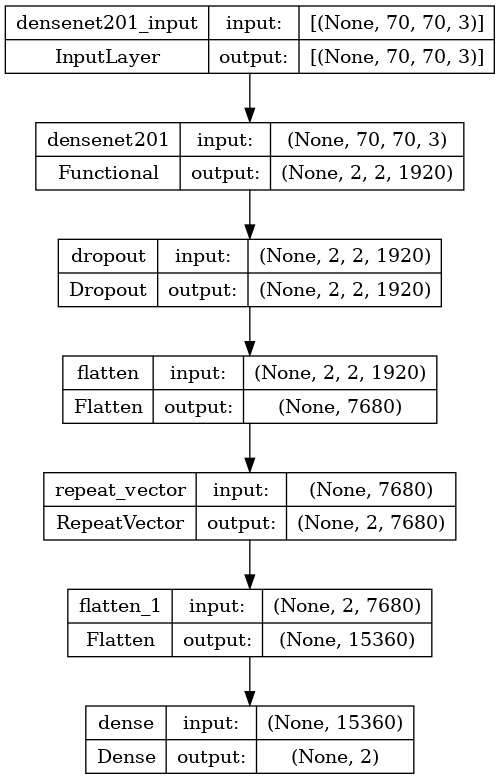

In [21]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [22]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [24]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.75, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=5)

In [25]:
model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=METRICS)

In [26]:
%time
history=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 12,callbacks=[lrd,mcp,es])

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs
Epoch 1/12


2023-10-16 08:06:58.227161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3447/3447 [==============================] - 199s 52ms/step - loss: 0.4015 - accuracy: 0.8654 - precision: 0.8654 - recall: 0.8654 - auc: 0.9216 - f1_score: 0.8654 - val_loss: 0.3593 - val_accuracy: 0.8852 - val_precision: 0.8852 - val_recall: 0.8852 - val_auc: 0.9327 - val_f1_score: 0.8851 - lr: 0.0010
Epoch 2/12
3447/3447 [==============================] - 136s 40ms/step - loss: 0.3616 - accuracy: 0.8716 - precision: 0.8716 - recall: 0.8716 - auc: 0.9291 - f1_score: 0.8716 - val_loss: 0.2804 - val_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878 - val_auc: 0.9490 - val_f1_score: 0.8877 - lr: 0.0010
Epoch 3/12
3447/3447 [==============================] - 137s 40ms/step - loss: 0.3349 - accuracy: 0.8755 - precision: 0.8755 - recall: 0.8755 - auc: 0.9350 - f1_score: 0.8755 - val_loss: 0.2703 - val_accuracy: 0.8960 - val_precision: 0.8960 - val_recall: 0.8960 - val_auc: 0.9519 - val_f1_score: 0.8959 - lr: 0.0010
Epoch 4/12
3447/3447 [==============================] - 135s 39

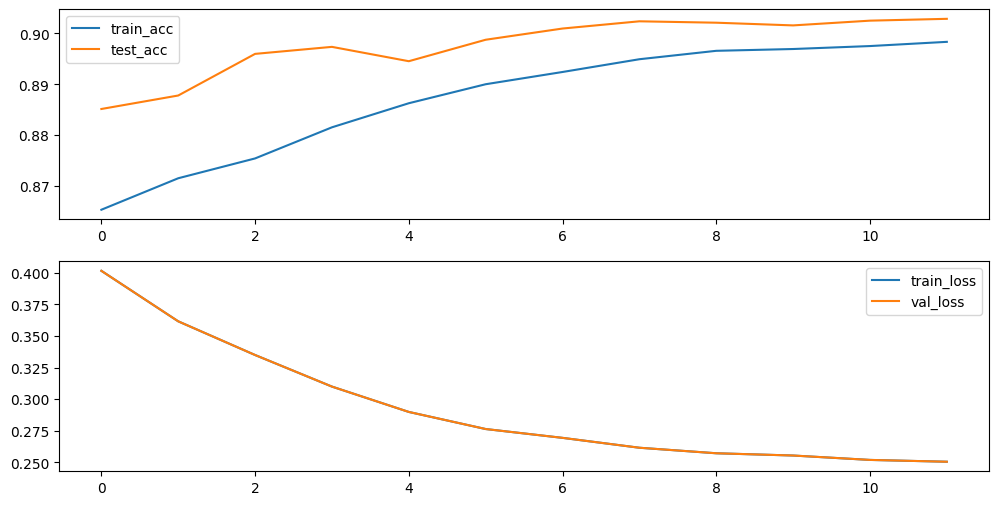

In [27]:
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['loss'], label = "val_loss")
plt.legend()

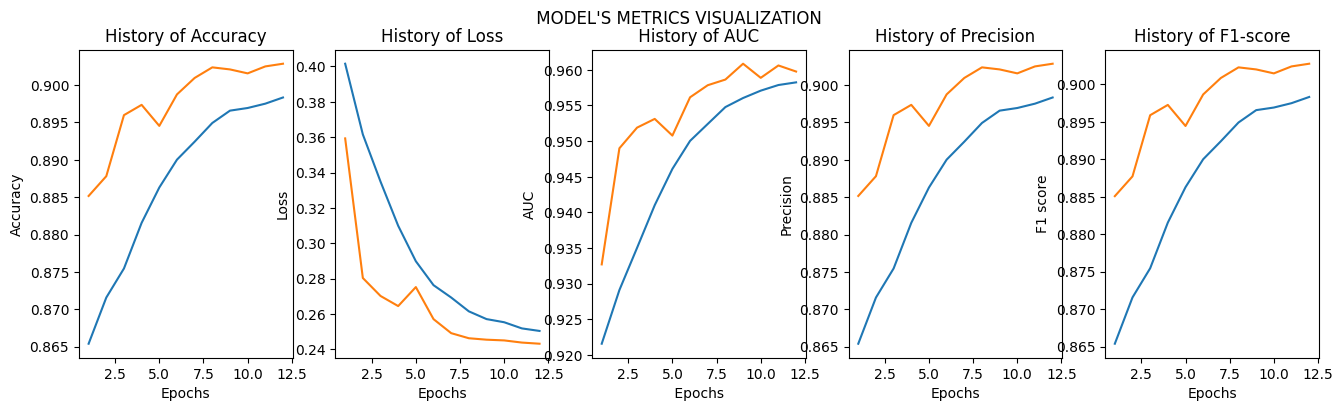

In [29]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (16,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    #ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    #ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title(' History of AUC ')
    ax3.set_xlabel(' Epochs ')
    ax3.set_ylabel('AUC')
    #ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    #ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    #ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score'])